# Imports

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


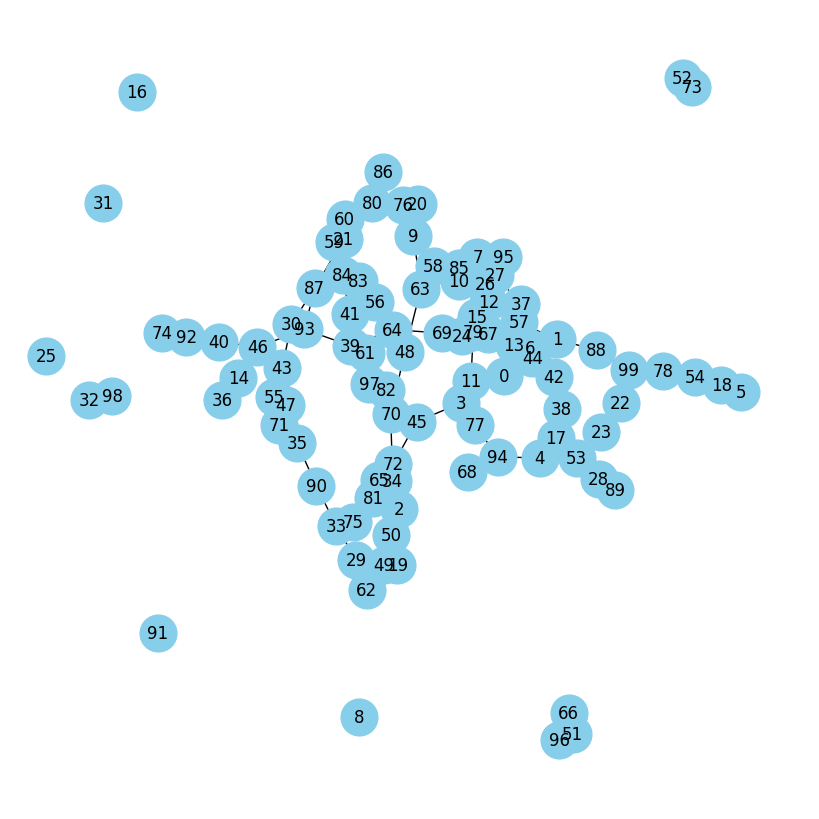

In [2]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



n = 100  # Number of nodes
P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


graph = configuration_B(n, P)
plot_graph(graph)

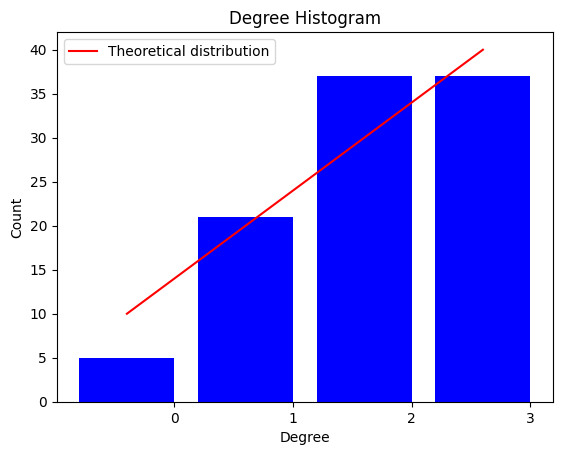

In [3]:
plot_degree_distribution(graph, P)

# Model2

Fits clustering and check with r and d

In [25]:
import networkx as nx
import random
import time
import signal

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

def model2(G, c_current, cluster, allowed_error, nodes_per_round, seed=42):
    # Seed the random number generator for reproducibility
    random.seed(seed)
    
    c_steps = [c_current]
    cluster_bound = [cluster - allowed_error, cluster + allowed_error]
    i = 0
    start_time = time.time()

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(3600)  # Set the alarm for one hour

    try:
        while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
            i += 1
            node_list = list(G.nodes())  # Refresh the node list

            # Ensure all nodes are connected to the largest component if not connected
            if not nx.is_connected(G):
                largest_cc = max(nx.connected_components(G), key=len)
                for node in node_list:
                    if node not in largest_cc:
                        G.add_edge(node, random.choice(list(largest_cc)))

            for node in node_list:
                if node not in G:
                    continue  # Ensure node still exists

                current_links = list(G.neighbors(node))

                if current_links:
                    # Randomly selects one link to remove
                    link_to_remove = random.choice(current_links)
                    G.remove_edge(node, link_to_remove)

                # Consider neighbors' neighbors
                extended_neighbors = set(current_links)
                for neighbor in current_links:
                    extended_neighbors.update(G.neighbors(neighbor))
                extended_neighbors.discard(node)  # Remove the node itself

                # Exclude current links and the node itself from potential new links
                possible_new_links = [n for n in node_list if n not in extended_neighbors]

                if len(possible_new_links) > nodes_per_round:
                    selected_nodes = random.sample(possible_new_links, nodes_per_round)
                else:
                    selected_nodes = possible_new_links

                c_possible = []

                for possible in selected_nodes:
                    G.add_edge(node, possible)
                    new_c = nx.average_clustering(G)
                    c_possible.append(new_c)
                    G.remove_edge(node, possible)

                if c_possible:
                    best_node = selected_nodes[c_possible.index(max(c_possible))]
                    G.add_edge(node, best_node)

            c_current = nx.average_clustering(G)
            c_steps.append(c_current)

        signal.alarm(0)  # Disable the alarm
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps

    except TimeoutException:
        print("Function execution failed due to timeout.")
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps  # Returning the graph, iteration count, and clustering steps so far

# Example usage:
G = nx.complete_graph(50)  # or any other graph initialization
result = model2(G, nx.average_clustering(G), 0.6, 0.02, 5)

Total execution time: 2.06 seconds


In [16]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [17]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [18]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [26]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [27]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [28]:
em_graph_avg = nx.average_clustering(em_graph)

In [29]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model, em_i, em_c_steps = model2(em_graph, em_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.09 seconds


In [30]:
em_model

In [31]:
em_i

24561

In [32]:
em_c_steps

[0.015165165165165166,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

Diameter of the graph: 6
Average Clustering Coefficient: 0.0


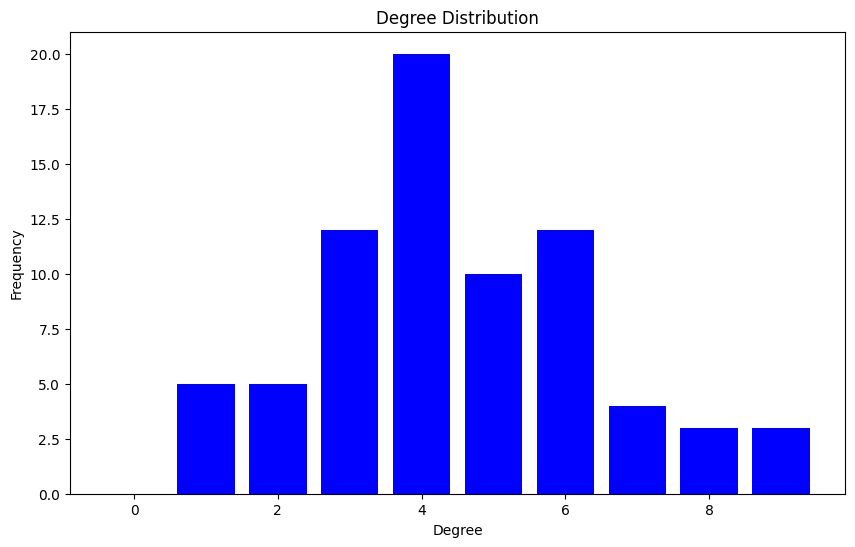

In [33]:
# compare calculated d and r values with actual values
analyze_graph(em_model)

In [34]:
nx.degree_assortativity_coefficient(em_model)

-0.14075955771521326

In [35]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [36]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [37]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [38]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model2(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

Total execution time: 2568.35 seconds


In [39]:
sioux_model

In [40]:
sioux_i

239700

In [41]:
sioux_c_steps

[0.09841269841269841,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


Diameter of the graph: 7
Average Clustering Coefficient: 0.05277777777777778


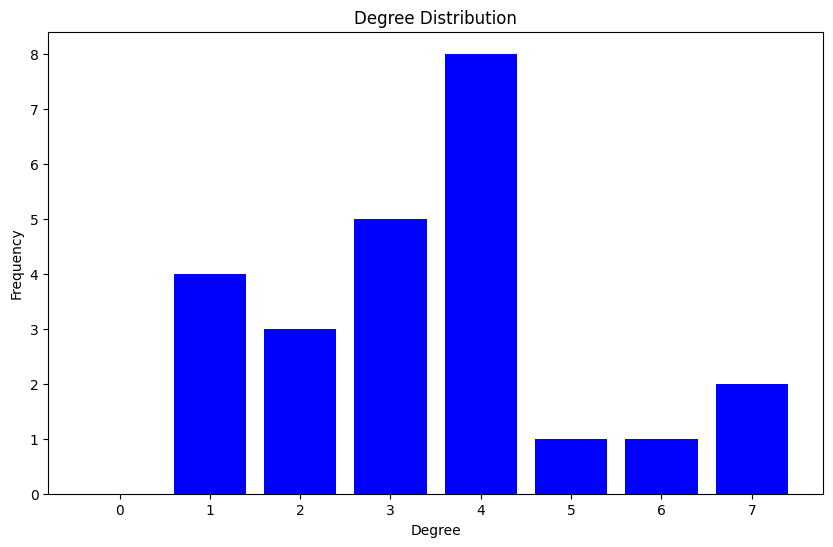

In [42]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [43]:
nx.degree_assortativity_coefficient(sioux_model)

0.16688741721854267

In [44]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [45]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [46]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [47]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model, bar_i, bar_c_steps = model2(bar_graph, bar_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3599.99 seconds


In [48]:
bar_model

In [49]:
bar_i

111

In [50]:
bar_c_steps

[0.0011860136211347284,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Graph is not connected; diameter of the giant component will be calculated.


Diameter of the giant component: 9
Average Clustering Coefficient: 0.0


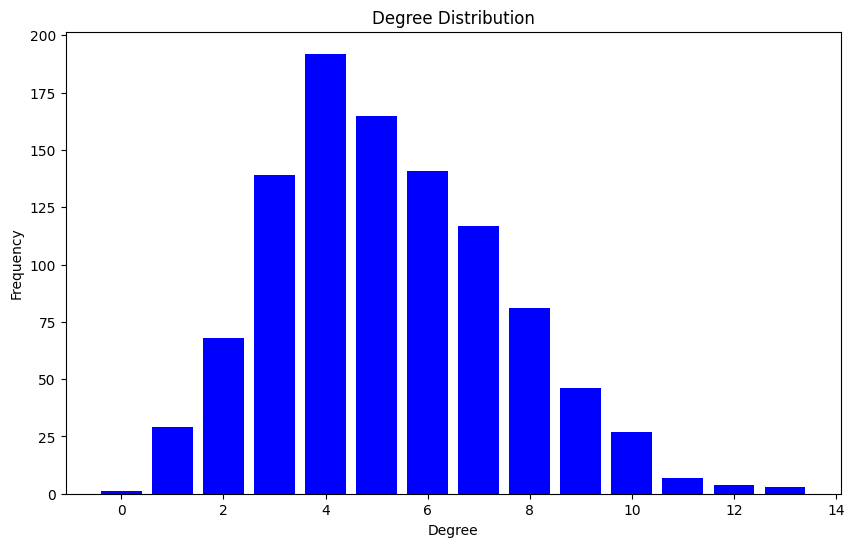

In [51]:
# compare calculated d and r values with actual values
analyze_graph(bar_model)

In [52]:
nx.degree_assortativity_coefficient(bar_model)

0.0020431941670825157

In [53]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [54]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [55]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [56]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model, syd_i, syd_c_steps = model2(syd_graph, syd_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3599.98 seconds


In [57]:
syd_model

In [58]:
syd_i

1

In [59]:
syd_c_steps

[4.307480007546736e-05]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 34
Average Clustering Coefficient: 4.3628427976226855e-05


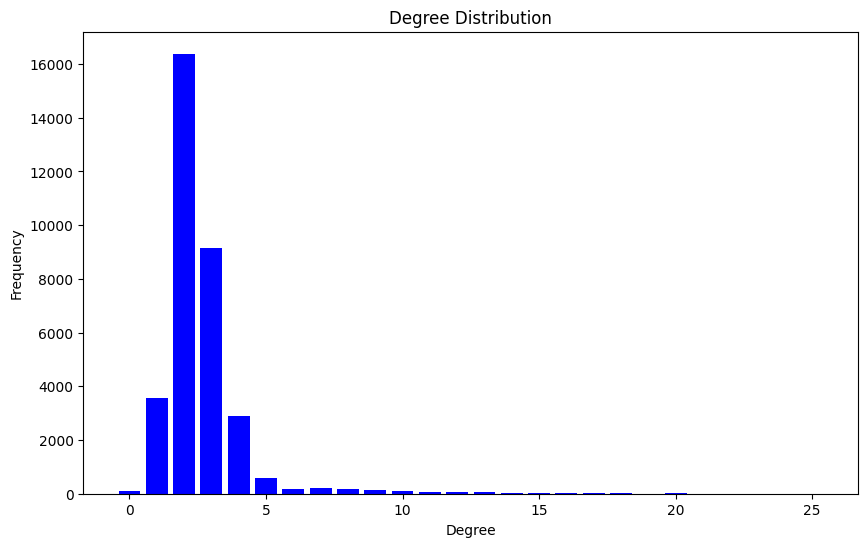

In [60]:
# compare calculated d and r values with actual values
analyze_graph(syd_model)

In [61]:
nx.degree_assortativity_coefficient(syd_model)

-0.009586059868769679

In [62]:
# get a degree distribution from Winnipeg
win_degrees = [win_net.degree(n) for n in win_net.nodes()]
win_degree_counts = np.bincount(win_degrees)

In [63]:
# make that random model with that
win_graph = configuration_B(1052, win_degree_counts)

In [64]:
win_graph_avg = nx.average_clustering(win_graph)

In [65]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1045
win_model, win_i, win_c_steps = model2(win_graph, win_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.10 seconds


In [66]:
win_model

In [67]:
win_i

99

In [68]:
win_c_steps

[0.0018030659665640653,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.0


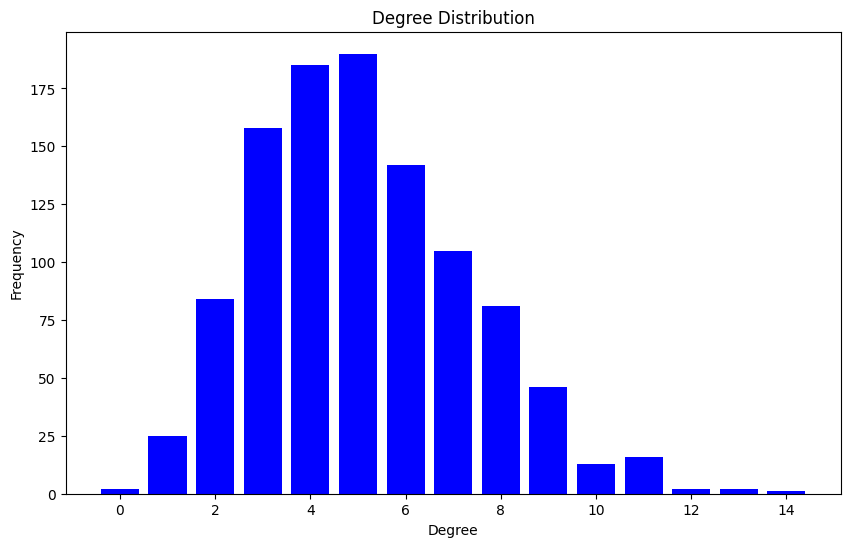

In [69]:
# compare calculated d and r values with actual values
analyze_graph(win_model)

In [70]:
nx.degree_assortativity_coefficient(win_model)

-0.014312091053947906

In [71]:
# get a degree distribution from Anaheim
ana_degrees = [ana_net.degree(n) for n in ana_net.nodes()]
ana_degree_counts = np.bincount(ana_degrees)

In [72]:
# make that random model with that
ana_graph = configuration_B(416, ana_degree_counts)

In [73]:
ana_graph_avg = nx.average_clustering(ana_graph)

In [74]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1076
ana_model, ana_i, ana_c_steps = model2(ana_graph, ana_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.10 seconds


In [75]:
ana_model

In [76]:
ana_i

528

In [77]:
ana_c_steps

[0.006019447966563351,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

Diameter of the graph: 6
Average Clustering Coefficient: 0.0


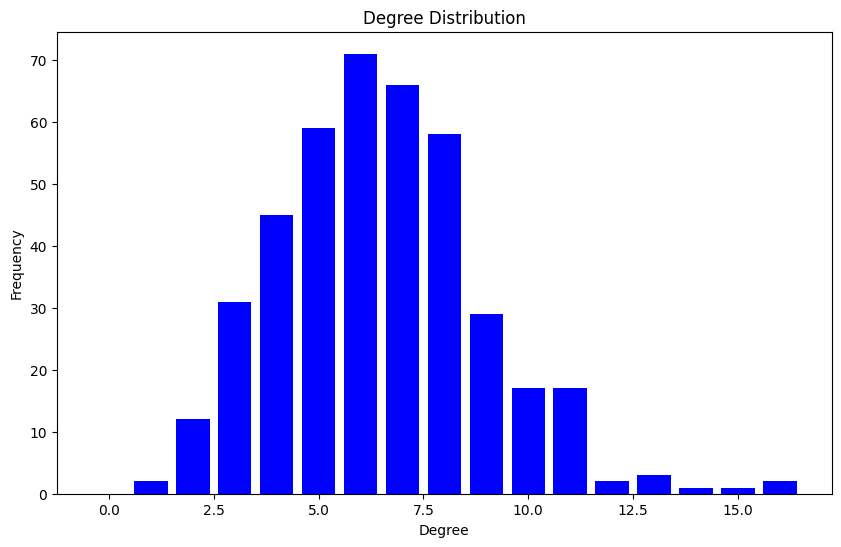

In [78]:
# compare calculated d and r values with actual values
analyze_graph(ana_model)

In [79]:
nx.degree_assortativity_coefficient(ana_model)

-0.0012075048343196924

In [80]:
# get a degree distribution from BerlinFriedrichshain
bf_degrees = [bf_net.degree(n) for n in bf_net.nodes()]
bf_degree_counts = np.bincount(bf_degrees)

In [81]:
# make that random model with that
bf_graph = configuration_B(224, bf_degree_counts)

In [82]:
bf_graph_avg = nx.average_clustering(bf_graph)

In [83]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1915
bf_model, bf_i, bf_c_steps = model2(bf_graph, bf_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.11 seconds


In [84]:
bf_model

In [85]:
bf_i

1872

In [86]:
bf_c_steps

[0.019951328433471287,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

Diameter of the graph: 6
Average Clustering Coefficient: 0.0


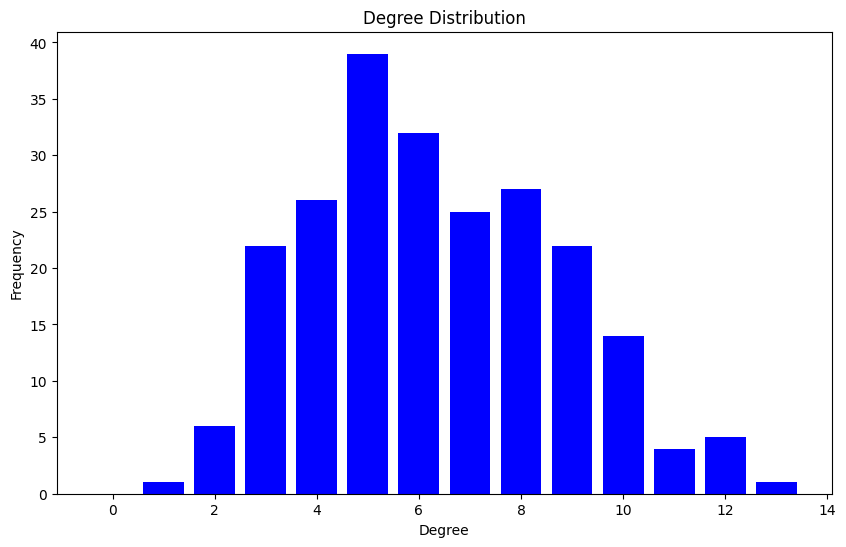

In [87]:
# compare calculated d and r values with actual values
analyze_graph(bf_model)

In [88]:
nx.degree_assortativity_coefficient(bf_model)

-0.03278001314868862

In [89]:
# get a degree distribution from Berlin-Mitte-Center
bmc_degrees = [bmc_net.degree(n) for n in bmc_net.nodes()]
bmc_degree_counts = np.bincount(bmc_degrees)

In [90]:
# make that random model with that
bmc_graph = configuration_B(398, bmc_degree_counts)

In [91]:
bmc_graph_avg = nx.average_clustering(bmc_graph)

In [92]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2048
bmc_model, bmc_i, bmc_c_steps = model2(bmc_graph, bmc_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.08 seconds


In [93]:
bmc_model

In [94]:
bmc_i

572

In [95]:
bmc_c_steps

[0.006975352955252452,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

Diameter of the graph: 6
Average Clustering Coefficient: 0.0


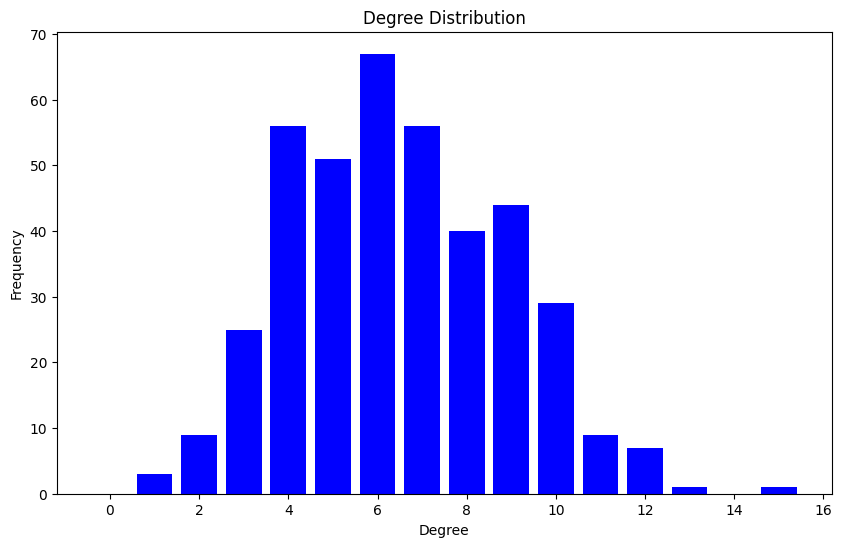

In [96]:
# compare calculated d and r values with actual values
analyze_graph(bmc_model)

In [97]:
nx.degree_assortativity_coefficient(bmc_model)

-0.010600745550963984